# Chapter 7 – Ensemble Learning and Random Forests

This notebook contains all the code samples and solutions to the exercises in chapter 7 of *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition* (O'Reilly). *Note: all code examples are based on the author's original GitHub repository.*

**Assignment Instructions:**
Per the assignment guidelines, this notebook reproduces the code from Chapter 7. It also includes theoretical explanations and summaries for each concept, as required.

## Chapter Summary

This chapter explores **Ensemble Learning**, a machine learning technique that aggregates the predictions of a group of predictors (called an *ensemble*) to get a better prediction than any single predictor. This is often called the "wisdom of the crowd."

The main methods covered are:
* **Voting Classifiers:** Combines different classifiers and makes a prediction based on the majority vote (hard voting) or on the average of predicted probabilities (soft voting). This works best when the classifiers are diverse and make uncorrelated errors.
* **Bagging and Pasting:** Uses the *same* algorithm for every predictor but trains them on different random subsets of the training data. **Bagging** (Bootstrap Aggregating) samples *with* replacement, while **Pasting** samples *without* replacement. These methods are great for parallelization and tend to reduce variance.
* **Random Forests:** An ensemble of Decision Trees, typically trained via bagging. To increase tree diversity, it also searches for the best feature among a *random subset* of features when splitting a node.
* **Boosting:** Trains predictors *sequentially*, where each new predictor tries to correct the errors made by its predecessor. We explore two main types:
    * **AdaBoost (Adaptive Boosting):** Focuses on instances the previous predictor underfitted by increasing their weights.
    * **Gradient Boosting:** Fits each new predictor to the *residual errors* made by the previous predictor.
* **Stacking (Stacked Generalization):** Instead of using a simple vote, this method trains a final model (a *blender* or *meta learner*) to perform the aggregation based on the predictions of the first-layer models.

## Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 3.7 or later is required for the latest versions of Scikit-Learn), as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Voting Classifiers

### Theoretical Explanation
Suppose you have trained a few different classifiers, such as a Logistic Regression classifier, an SVM classifier, and a Random Forest classifier. A very simple way to create an even better classifier is to aggregate the predictions of each classifier and predict the class that gets the most votes. This is called a **hard voting classifier**.

This works surprisingly well because of the **law of large numbers**. Even if each classifier is a *weak learner* (meaning it performs only slightly better than random guessing), the ensemble can be a *strong learner* (achieving high accuracy), *provided* there are a sufficient number of weak learners and they are sufficiently independent (i.e., they make uncorrelated errors).

If all classifiers can estimate class probabilities (i.e., they have a `predict_proba()` method), you can average these probabilities across all classifiers and predict the class with the highest average probability. This is called **soft voting**. It often performs better than hard voting because it gives more weight to high-confidence votes.

In [2]:
# Code to demonstrate a Hard Voting Classifier

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [3]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


Now let's try a soft voting classifier. We just need to set `voting='soft'` and ensure all classifiers can output probabilities. For the `SVC`, this means setting `probability=True`.

In [4]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42) # Set probability=True

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft'
)

voting_clf.fit(X_train, y_train)

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


Soft voting achieved an even higher accuracy (91.2%) than hard voting (90.4%).

## Bagging and Pasting

### Theoretical Explanation
Another approach to get a diverse set of classifiers is to use the **same** training algorithm for every predictor but train them on different random subsets of the training set.

* **Bagging** (short for *Bootstrap Aggregating*): Sampling is performed **with replacement** (i.e., bootstrapping).
* **Pasting:** Sampling is performed **without replacement**.

Once all predictors are trained, the ensemble makes a prediction by aggregating their predictions:
* **Classification:** The statistical **mode** (i.e., the most frequent prediction).
* **Regression:** The **average**.

Each individual predictor has a higher bias (since it's trained on a smaller subset of data), but aggregation reduces both bias and variance. Overall, the ensemble has a similar bias but a **lower variance** than a single predictor trained on the original dataset.

A key feature of bagging and pasting is that all predictors can be trained in parallel, making these methods very scalable.

### Code Reproduction: Bagging in Scikit-Learn

The following code trains an ensemble of 500 Decision Tree classifiers, each trained on 100 training instances randomly sampled from the training set *with replacement* (this is bagging, `bootstrap=True`).

We will compare the decision boundary of a single Decision Tree to the bagging ensemble.

In [5]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42),
    n_estimators=500,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
bag_clf.fit(X_train, y_train)

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

Saving figure decision_tree_without_and_with_bagging_plot


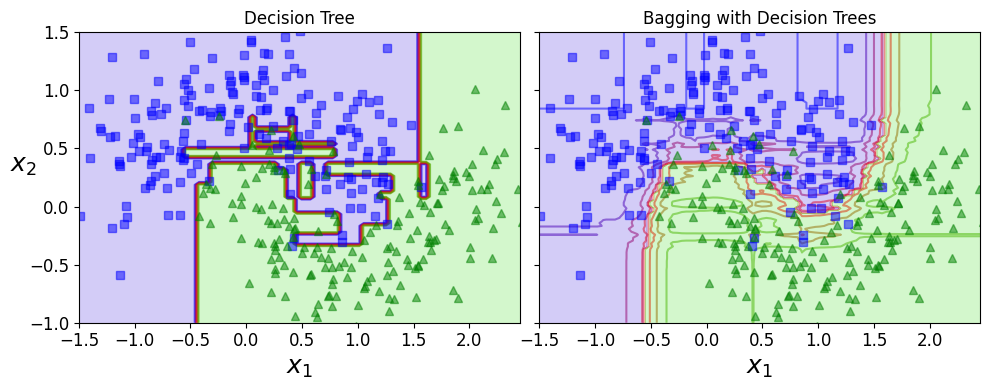

In [6]:
# Helper functions to plot decision boundaries (from previous chapters)
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    plt.contourf(x1, x2, y_pred, cmap=plt.cm.brg, alpha=0.2)
    if contour:
        y_decision = clf.predict_proba(X_new)[:, 1].reshape(x1.shape)
        plt.contour(x1, x2, y_decision, cmap=plt.cm.brg, alpha=0.5)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("Decision Tree")
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("Bagging with Decision Trees")
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

This figure (which reproduces Figure 7-5 from the book) shows that the ensemble’s decision boundary is less irregular and will likely generalize much better than the single Decision Tree.

### Theoretical Explanation: Out-of-Bag (OOB) Evaluation

With bagging, some instances may be sampled several times for any given predictor, while others may not be sampled at all. By default, `BaggingClassifier` samples *m* training instances with replacement, where *m* is the size of the training set.

This means that only about **63%** of the training instances are sampled on average for each predictor. The remaining **37%** of the instances that are not sampled are called **out-of-bag (OOB) instances**.

Since a predictor never sees the OOB instances during training, it can be evaluated on these instances, without the need for a separate validation set. You can evaluate the ensemble itself by averaging out the OOB evaluations of each predictor.

In Scikit-Learn, you can set `oob_score=True` to request an automatic OOB evaluation after training.

In [7]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42),
    n_estimators=500,
    bootstrap=True,
    n_jobs=-1,
    oob_score=True,  # Request OOB evaluation
    random_state=42
)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

In [8]:
# Let's verify against the test set accuracy
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

The OOB score (90.1%) is very close to the test set accuracy (91.2%).

The OOB decision function for each training instance is also available:

In [9]:
bag_clf.oob_decision_function_[:10] # Probabilities for the first 10 training instances

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.06145251, 0.93854749],
       [0.35465116, 0.64534884],
       [0.01142857, 0.98857143],
       [0.98930481, 0.01069519],
       [0.97927461, 0.02072539]])

### Theoretical Explanation: Random Patches and Random Subspaces

`BaggingClassifier` also supports sampling the features, which is controlled by `max_features` and `bootstrap_features`.

* **Random Patches Method:** This involves sampling *both* training instances and features. This is useful for high-dimensional inputs (like images).
* **Random Subspaces Method:** This involves keeping *all* training instances (by setting `bootstrap=False` and `max_samples=1.0`) but sampling features (by setting `bootstrap_features=True` and/or `max_features` to a value < 1.0).

Sampling features results in even more predictor diversity, trading a bit more bias for a lower variance.

## Random Forests

### Theoretical Explanation

A **Random Forest** is an ensemble of Decision Trees, generally trained via the bagging method (or sometimes pasting), typically with `max_samples` set to the size of the training set.

Instead of using a `BaggingClassifier` and passing it a `DecisionTreeClassifier`, you can use the `RandomForestClassifier` class, which is more convenient and optimized for Decision Trees.

A Random Forest introduces **extra randomness** when growing trees. Instead of searching for the *best* feature when splitting a node, it searches for the best feature among a **random subset of features**. This results in greater tree diversity, which (again) trades a higher bias for a lower variance, generally yielding an overall better model.

In [10]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred_rf)

0.912

A `BaggingClassifier` is roughly equivalent to a `RandomForestClassifier` with the following settings:

In [11]:
bag_clf_equiv = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42
)

### Theoretical Explanation: Extra-Trees

When you are growing a tree in a Random Forest, at each node only a random subset of the features is considered for splitting.

It is possible to make trees even more random by also using **random thresholds** for each feature rather than searching for the *best possible* thresholds. A forest of such trees is called an **Extremely Randomized Trees** ensemble (or **Extra-Trees**).

This trades more bias for a lower variance. It also makes Extra-Trees **much faster to train** than regular Random Forests, because finding the best threshold is one of the most time-consuming tasks of training a Decision Tree.

You can create one using `ExtraTreesClassifier`.

### Theoretical Explanation: Feature Importance

A great quality of Random Forests is that they make it easy to measure the relative importance of each feature.

Scikit-Learn measures a feature’s importance by looking at how much the tree nodes that use that feature reduce impurity on average (across all trees in the forest). More precisely, it is a weighted average, where each node’s weight is equal to the number of training samples associated with it.

Scikit-Learn computes this score automatically for each feature after training and scales the results so that the sum of all importances is equal to 1.

In [12]:
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])

for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


This shows that the most important features are the petal length (44%) and petal width (42%), while sepal length and width are not very important.

## Boosting

### Theoretical Explanation

**Boosting** (originally *hypothesis boosting*) refers to any Ensemble method that can combine several weak learners into a strong learner. The general idea of most boosting methods is to train predictors **sequentially**, each trying to correct its predecessor.

The two most popular methods are **AdaBoost** and **Gradient Boosting**.

### Theoretical Explanation: AdaBoost

**AdaBoost (Adaptive Boosting)** works by paying more attention to the training instances that the predecessor underfitted.

Here is the algorithm:
1.  A base classifier (e.g., a Decision Tree) is trained. Each instance weight $w^{(i)}$ is initially set to $1/m$.
2.  The classifier makes its predictions, and its **weighted error rate** $r_1$ is computed.
3.  The classifier's weight $\alpha_j$ is computed based on its error rate. The more accurate it is, the higher its weight.
4.  The instance weights are updated: the weights of the **misclassified instances are boosted** (multiplied by $\exp(\alpha_j)$).
5.  All instance weights are normalized.
6.  A new classifier is trained on the updated weights, and the process is repeated.

**Prediction:** AdaBoost makes predictions by computing the predictions of all predictors and weighting them using the predictor weights $\alpha_j$. The predicted class is the one that receives the majority of weighted votes.

**Drawback:** This sequential learning cannot be parallelized, so it does not scale as well as bagging or pasting.

In [14]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1, random_state=42),
    n_estimators=200,
    algorithm="SAMME",
    learning_rate=0.5,
    random_state=42
)
ada_clf.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1,
                                                    random_state=42),
                   learning_rate=0.5, n_estimators=200, random_state=42)

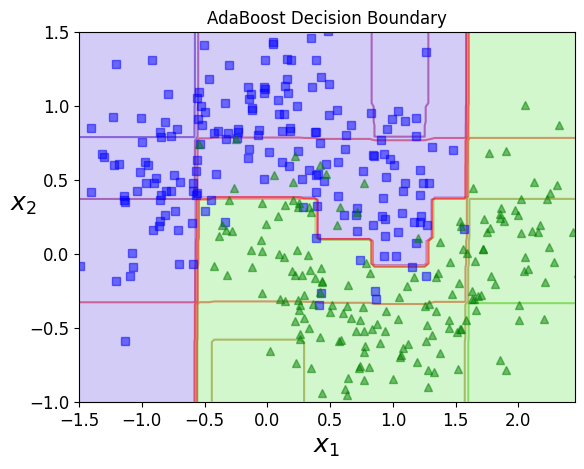

In [15]:
# Plotting the decision boundary
plot_decision_boundary(ada_clf, X_train, y_train)
plt.title("AdaBoost Decision Boundary")
plt.show()

### Theoretical Explanation: Gradient Boosting

**Gradient Boosting** is another popular boosting algorithm that also works by sequentially adding predictors to an ensemble, each one correcting its predecessor.

**Key Difference:** Instead of tweaking the instance weights at every iteration, Gradient Boosting tries to fit the new predictor to the **residual errors** made by the previous predictor.

Let's walk through a simple regression example using Decision Trees, known as **Gradient Tree Boosting (GBRT)**:
1.  First, fit a `DecisionTreeRegressor` to the training set.
2.  Next, train a second `DecisionTreeRegressor` on the **residual errors** (e.g., $y_2 = y - \text{tree}_1.\text{predict}(X)$) made by the first predictor.
3.  Then, train a third regressor on the residual errors of the second predictor (e.g., $y_3 = y_2 - \text{tree}_2.\text{predict}(X)$).
4.  This is repeated until the desired number of estimators is reached.
5.  To make a prediction, you simply **add up the predictions** of all the trees.

A hyperparameter called `learning_rate` scales the contribution of each tree. This is a regularization technique called **shrinkage**. A low learning rate (e.g., 0.1) requires more trees but often generalizes better.

In [16]:
# Manually implementing a simple GBRT
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

from sklearn.tree import DecisionTreeRegressor

# 1. Train the first tree
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

# 2. Train the second tree on the residuals of the first
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

# 3. Train the third tree on the residuals of the second
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

# Make predictions by summing the predictions of all trees
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
print(y_pred)

[0.75026781]


#### Gradient Boosting with Scikit-Learn
A simpler way to train GBRT ensembles is to use Scikit-Learn’s `GradientBoostingRegressor` class.

In [17]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)
print(gbrt.predict(X_new))

[0.75026781]


#### Finding the Optimal Number of Trees with Early Stopping

A low `learning_rate` requires more trees. To find the optimal number of trees, you can use **early stopping**.

A simple way is to use `staged_predict()`: it returns an iterator over the predictions made by the ensemble at each stage of training (with one tree, two trees, etc.). We can stop when the validation error stops improving.

In [18]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]

bst_n_estimators = np.argmin(errors) + 1
print("Optimal number of estimators:", bst_n_estimators)

# Train a new GBRT with the optimal number of estimators
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

Optimal number of estimators: 118


GradientBoostingRegressor(max_depth=2, n_estimators=np.int64(118),
                          random_state=42)

## Stacking

### Theoretical Explanation

**Stacking** (short for *stacked generalization*) is the last ensemble method we will discuss. It is based on a simple idea: instead of using a trivial function (like voting) to aggregate the predictions, why not train a model to perform this aggregation?

Each predictor in the first layer predicts a value, and then a final predictor (called a **blender** or **meta learner**) takes these predictions as inputs and makes the final prediction.

**Training a Blender:**
1.  The training set is split into two subsets.
2.  The first subset is used to train the predictors in the first layer.
3.  The first-layer predictors are used to make predictions on the second (held-out) subset.
4.  This creates a new training set. The input features are the predictions from the first-layer models, and the targets are the original target values.
5.  The blender is trained on this new training set. It learns to combine the first layer's predictions to best predict the target.

Scikit-Learn does not support stacking directly, but it is not hard to implement (it is an exercise at the end of the chapter).

## Exercises

From Chapter 7, page 211:

1.  If you have trained five different models on the exact same training data, and they all achieve 95% precision, is there any chance that you can combine these models to get better results? If so, how? If not, why?
2.  What is the difference between hard and soft voting classifiers?
3.  Is it possible to speed up training of a bagging ensemble by distributing it across multiple servers? What about pasting ensembles, boosting ensembles, Random Forests, or stacking ensembles?
4.  What is the benefit of out-of-bag evaluation?
5.  What makes Extra-Trees more random than regular Random Forests? How can this extra randomness help? Are Extra-Trees slower or faster than regular Random Forests?
6.  If your AdaBoost ensemble underfits the training data, which hyperparameters should you tweak and how?
7.  If your Gradient Boosting ensemble overfits the training set, should you increase or decrease the learning rate?
8.  Load the MNIST data, split it, and train various classifiers (e.g., Random Forest, Extra-Trees, SVM). Then, try to combine them into an ensemble that outperforms each individual classifier on the validation set, using soft or hard voting.
9.  Run the individual classifiers from the previous exercise to make predictions on the validation set, and create a new training set with the resulting predictions: each training instance is a vector containing the set of predictions from all your classifiers for an image, and the target is the image’s class. Train a classifier on this new training set. Congratulations, you have just trained a blender, and together with the classifiers it forms a stacking ensemble! Evaluate the ensemble on the test set.